In [1]:
!pip install pmdarima
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.1 MB/s 
     |████████████████████████████████| 9.9 MB 51.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [2]:
import warnings
warnings.simplefilter(action='ignore')
import os
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import statsmodels.api as sm
from scipy import signal
import pmdarima as pm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df_data = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/Part1 Data.csv')
df_trends_raw = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/US_WI_55079.xlsx')
df_columns = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/trends_columns.xlsx')
df_vaccine = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/Vaccination Search Insights.xlsx')

In [4]:
cols = list(df_columns['column'])
df_trends = df_trends_raw[df_trends_raw.columns.intersection(cols)]
df_trends = df_trends[(df_trends['date'] >= '2020-02-01') & (df_trends['date'] <= '2021-10-01')]
df_trends.head()

,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,search_trends_visual_acuity,search_trends_vomiting,search_trends_wart,search_trends_water_retention,search_trends_weakness,search_trends_weight_gain,search_trends_wheeze,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn
31,2020-02-01,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.15,3.08,1.09,0.23,0.36,3.02,0.23,2.33,0.32,0.16
32,2020-02-02,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.42,1.23,0.26,0.36,3.35,0.27,2.32,0.30,0.21
33,2020-02-03,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.18,2.99,1.13,0.22,0.34,3.27,0.30,1.96,0.33,0.14
34,2020-02-04,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.24,2.63,1.22,0.26,0.46,3.11,0.25,1.89,0.41,0.20
35,2020-02-05,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.02,1.10,0.31,0.37,3.05,0.26,2.14,0.37,0.16


In [5]:
print(df_data.shape, df_trends.shape, df_vaccine.shape)

(609, 18) (609, 425) (88, 5)


In [6]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_main =  df_trends.merge(df_data, how='inner', on='date')
df_main = df_main.merge(df_vaccine, how = 'left', on = 'date')
df_main['mask_required'] = df_main['mask_required'].replace(np.nan, 'No')
df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']] = df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']].replace(np.nan, 0)
print(df_main.shape)
df_main.head()

(609, 446)


,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,infected,susceptible,transmission_rate,infection_rate,r0,derivative,key,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2020-02-01,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020-02-02,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-02-03,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-02-04,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-02-05,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
import ruptures as rpt
data = np.array(df_main['infection_rate'])

algo = rpt.Pelt(model="rbf").fit(data)
change_location = algo.predict(pen = 5)
change_location = df_main.iloc[change_location[:-1]]['date'].to_list()

In [8]:
covid_symptoms = ['search_trends_sore_throat', 'search_trends_chills', 'search_trends_fever', 'search_trends_cough', 'search_trends_sinusitis', 
'search_trends_common_cold', 'search_trends_shortness_of_breath', 'search_trends_shallow_breathing', 'search_trends_fatigue', 'search_trends_muscle_weakness', 
'search_trends_headache', 'search_trends_nasal_congestion', 'search_trends_nausea', 'search_trends_vomiting', 'search_trends_diarrhea', 'search_trends_pneumonia']

covid_symptoms_short = [item.replace('search_trends_', '') for item in covid_symptoms]
covid_symptoms_short = [item.replace('_', ' ') for item in covid_symptoms_short]

df_main[covid_symptoms] = df_main[covid_symptoms].rolling(4).mean().fillna(0)
df_wave1 = df_main[(df_main['date'] >= '2020-03-01') & (df_main['date'] < '2020-08-01')]
df_wave2 = df_main[(df_main['date'] >= '2020-08-01') & (df_main['date'] <= '2021-03-30')]
df_wave3 = df_main[df_main['date'] >= '2021-03-30']
df_wave1.reset_index(inplace = True)
df_wave2.reset_index(inplace = True)
df_wave3.reset_index(inplace = True)
df_wave1[covid_symptoms_short] = df_wave1[covid_symptoms]
df_wave1 = df_wave1.drop(covid_symptoms, axis = 1)
df_wave2[covid_symptoms_short] = df_wave2[covid_symptoms]
df_wave2 = df_wave2.drop(covid_symptoms, axis = 1)
df_wave3[covid_symptoms_short] = df_wave3[covid_symptoms]
df_wave3 = df_wave3.drop(covid_symptoms, axis = 1)

### Analyze the correlation between Confirmed cases and COVID symptom search terms

In [9]:
def cross_correlation(predictors):
  data_cases = pd.DataFrame(columns = predictors.columns)
  data_deaths = pd.DataFrame(columns = predictors.columns)
  for i in predictors.columns:
    corrs_cases = sm.tsa.stattools.ccf(predictors['cases'], predictors[[i]], adjusted=False)
    corrs_deaths = sm.tsa.stattools.ccf(predictors['deaths'], predictors[[i]], adjusted=False)
    data_cases[i] = corrs_cases[0:14]
    data_deaths[i] = corrs_deaths[0:22]
  data_cases, data_deaths = data_cases.abs(), data_deaths.abs()
  data_cases = data_cases.reset_index().rename(columns={"index": "lag"})
  data_deaths = data_deaths.reset_index().rename(columns={"index": "lag"})
  corr_coeff_cases = data_cases[data_cases['lag'] == 0]
  corr_coeff_deaths = data_deaths[data_deaths['lag'] == 0]
  data_cases = data_cases[data_cases['lag']!=0]
  data_deaths = data_deaths[data_deaths['lag']!=0]
  return data_cases, data_deaths, corr_coeff_cases, corr_coeff_deaths

In [10]:
top_symptoms = ['cough', 'fever', 'sore throat', 'shortness of breath', 'pneumonia']

In [11]:
from sklearn.preprocessing import MinMaxScaler
viz_trends = pd.DataFrame()
for i in top_symptoms:
  col = i.replace(' ', '_')
  col = 'search_trends_' + col
  viz_trends[col] = df_main[col]
  viz_trends[col+'_comp'] = max(df_main[col]) - df_main[col]
  scaler = MinMaxScaler()
  alphas = scaler.fit_transform(np.flip(np.array(df_main[col]).reshape(-1,1)))
  alphas = np.flip(alphas)
  viz_trends['alphas'] = alphas

viz_trends['date'] = df_main['date']

In [12]:
def plot_trends(cols):
  plt.rcParams["figure.figsize"] = (30, 5)
  for i in range(len(cols)):
    col = cols[i].replace(' ', '_')
    col = 'search_trends_' + col
    fig, ax = plt.subplots(1, 1)
    ax.bar(viz_trends['date'], viz_trends[col], color = '#00461B', edgecolor='#00461B', align='center', width = 5)
    ax.bar(viz_trends['date'], viz_trends[col+'_comp'], color = '#EEE1C8', edgecolor='#EEE1C8', bottom=viz_trends[col], align='center', width = 2)
    loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
    plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
    plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2020-08-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2021-04-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
    for x in change_location:
      plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')
    xmin = min(viz_trends['date'])
    xmax = max(viz_trends['date'])
    ax.set_xlim([xmin, xmax])
    ax.set(title = f'Google Search Trends for %s Symptom in Milwaukee'% cols[i].upper(), xlabel='Search Date',ylabel='Realtive Search Value (RSV)')
    for bar, alpha in zip(ax.containers[0], viz_trends['alphas']):
      bar.set_alpha(alpha)

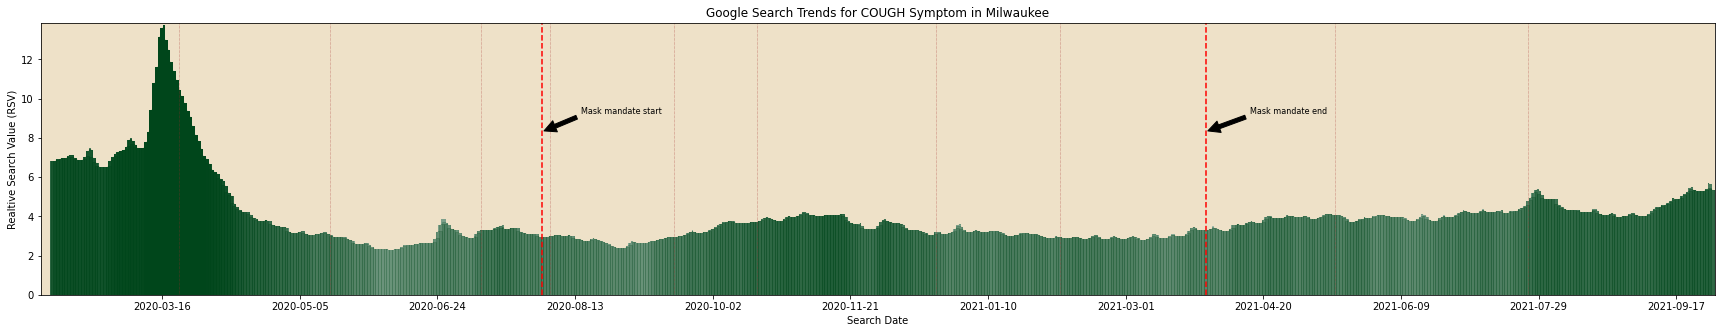

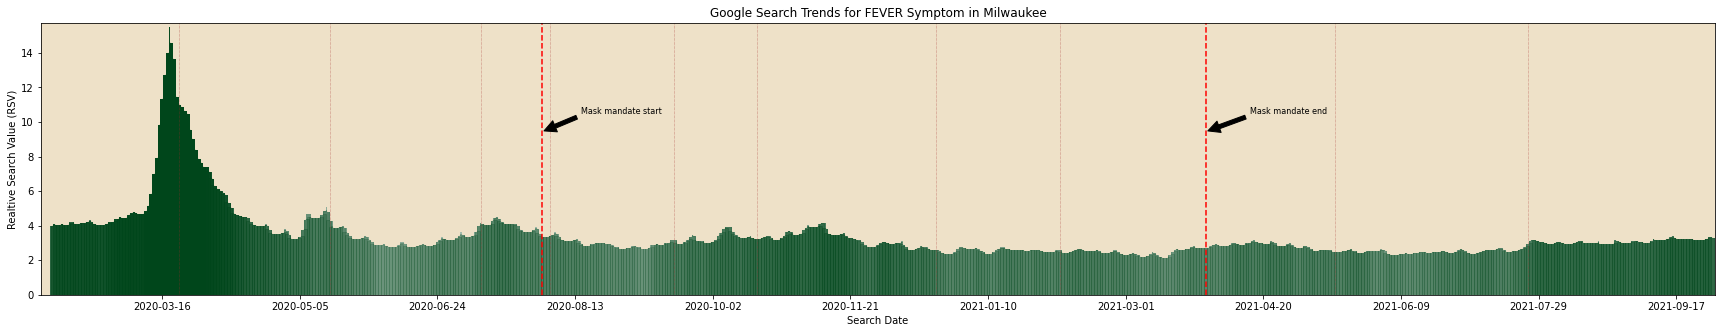

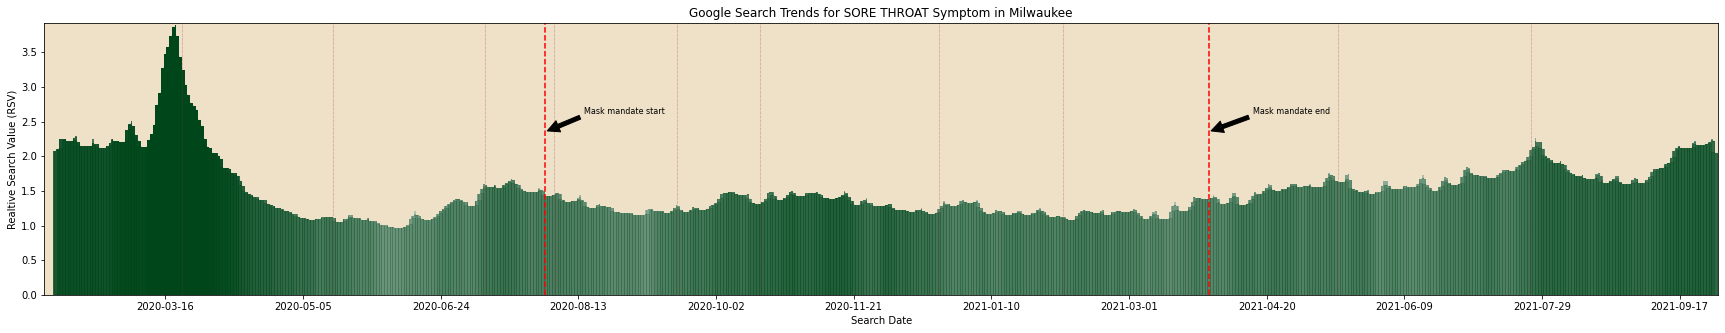

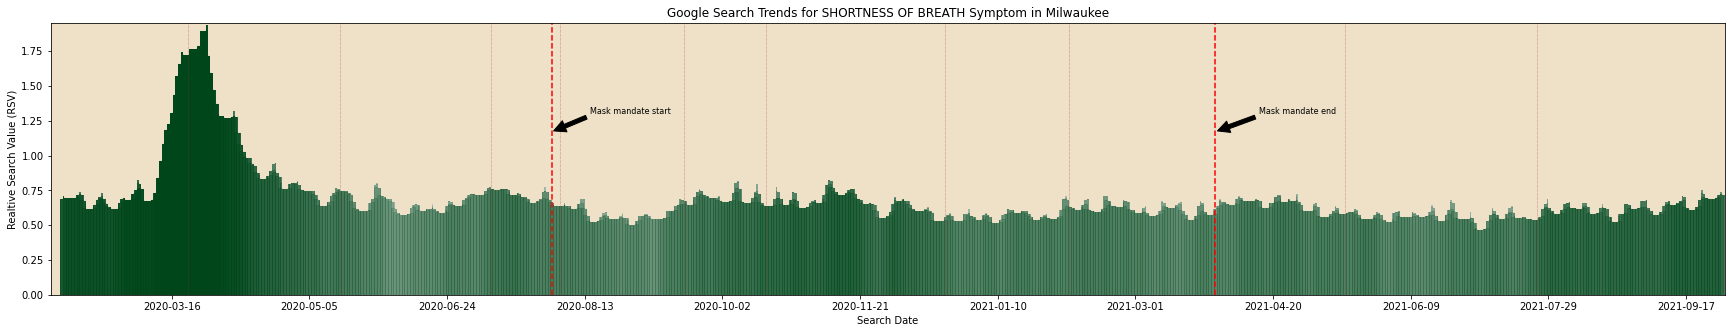

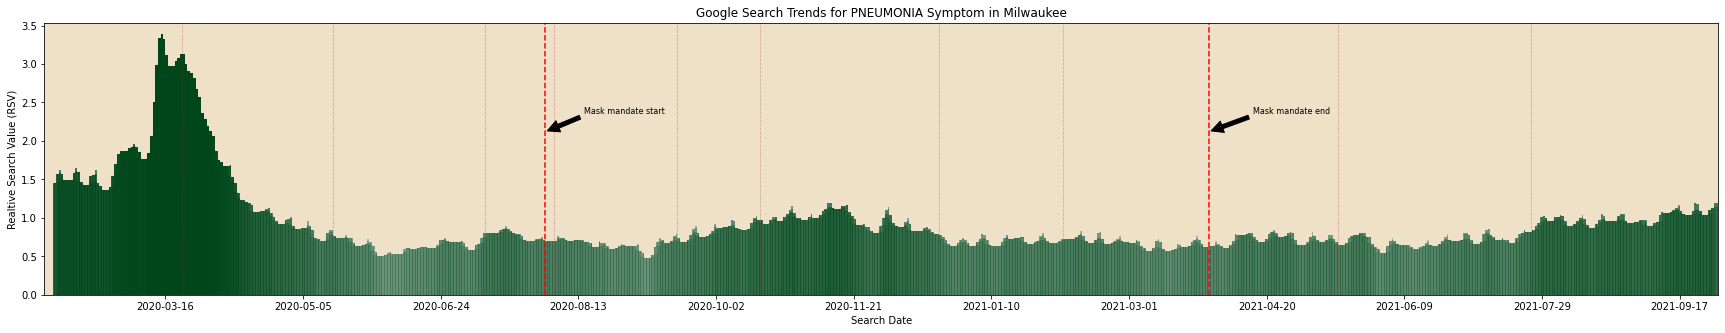

In [13]:
plot_trends(top_symptoms)

### Obtain the time-lagged cross correlation between the COVID confirmed cases and top COVID symptom search terms

In [37]:
def crosscorr(datax, datay, lag = 0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

def window_corr(data, column):
  # Rolling window time lagged cross correlation
  window_size = 60 #samples
  t_start = 0
  t_end = t_start + window_size
  step_size = 2
  rss = []
  while t_end < data.shape[0]:
      d1 = data['cases'].iloc[t_start:t_end]
      d2 = data[column].iloc[t_start:t_end]
      rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(0, 15)]
      rss.append(rs)
      t_start = t_start + step_size
      t_end = t_end + step_size
  rss = pd.DataFrame(rss)
  return rss

def plot_corr(data1, data2, data3, column):
  f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 18))
  f.suptitle('Time Lagged Correlation plots before, during and after mask mandate in Milwaukee County')
  sns.heatmap(data1, cmap='RdBu_r',ax=ax1)
  ax1.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) before mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax1.set_xticklabels([int(item) for item in ax1.get_xticks()]);
  sns.heatmap(data2, cmap='RdBu_r',ax=ax2)
  ax2.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) during mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax2.set_xticklabels([int(item) for item in ax2.get_xticks()]);
  sns.heatmap(data3, cmap='RdBu_r',ax=ax3)
  ax3.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) after mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax3.set_xticklabels([int(item) for item in ax3.get_xticks()]);

In [38]:
def plot_corr2(data, column):
  f, ax = plt.subplots(1, figsize=(12, 18))
  f.suptitle('Time Lagged Correlation plots before, during and after mask mandate in Milwaukee County')
  sns.heatmap(data, cmap='RdBu_r',ax=ax)
  ax.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) before mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax.set_xticklabels([int(item) for item in ax.get_xticks()]);

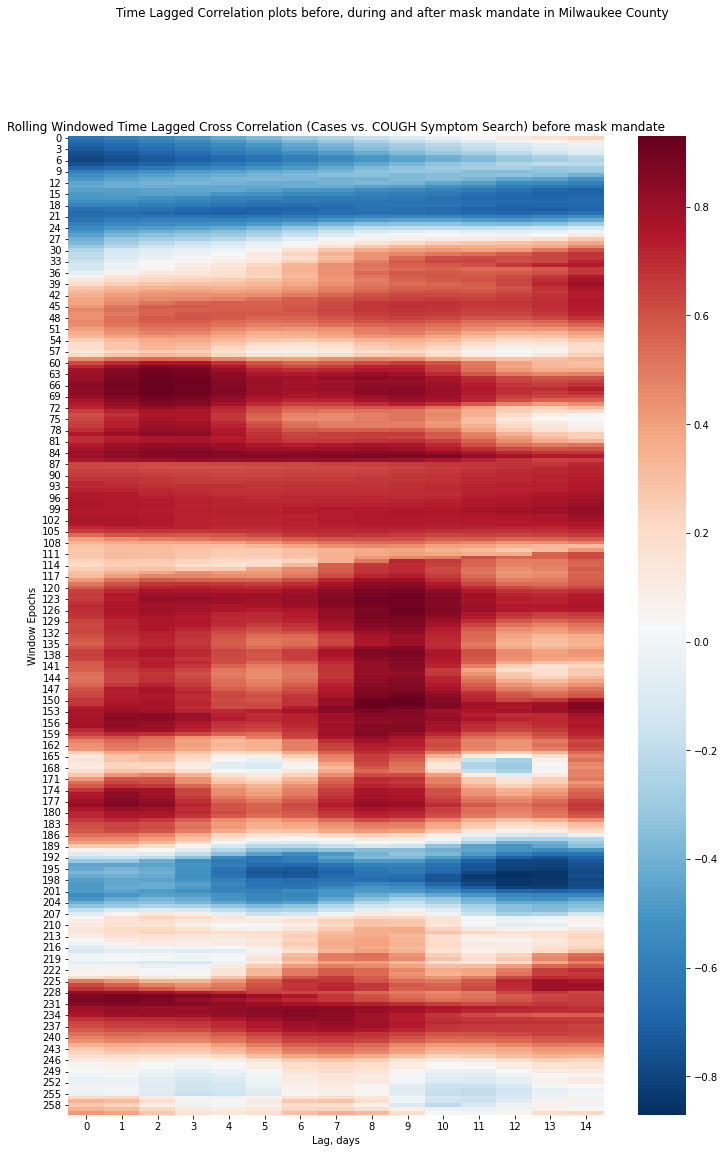

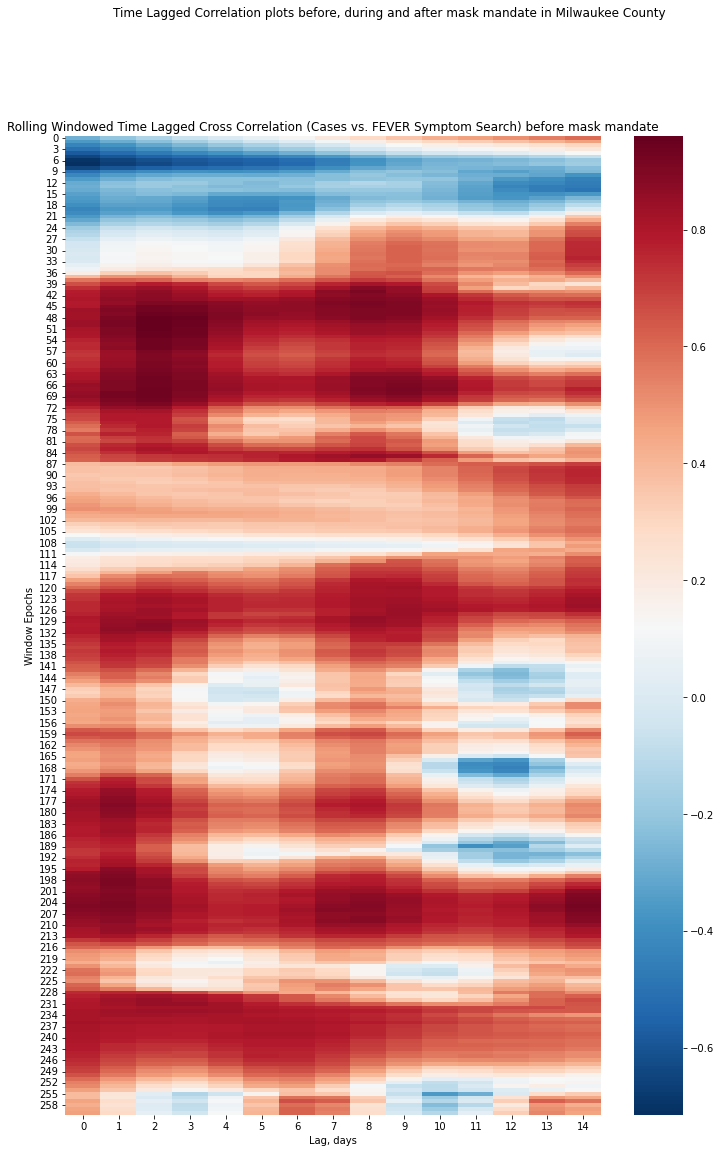

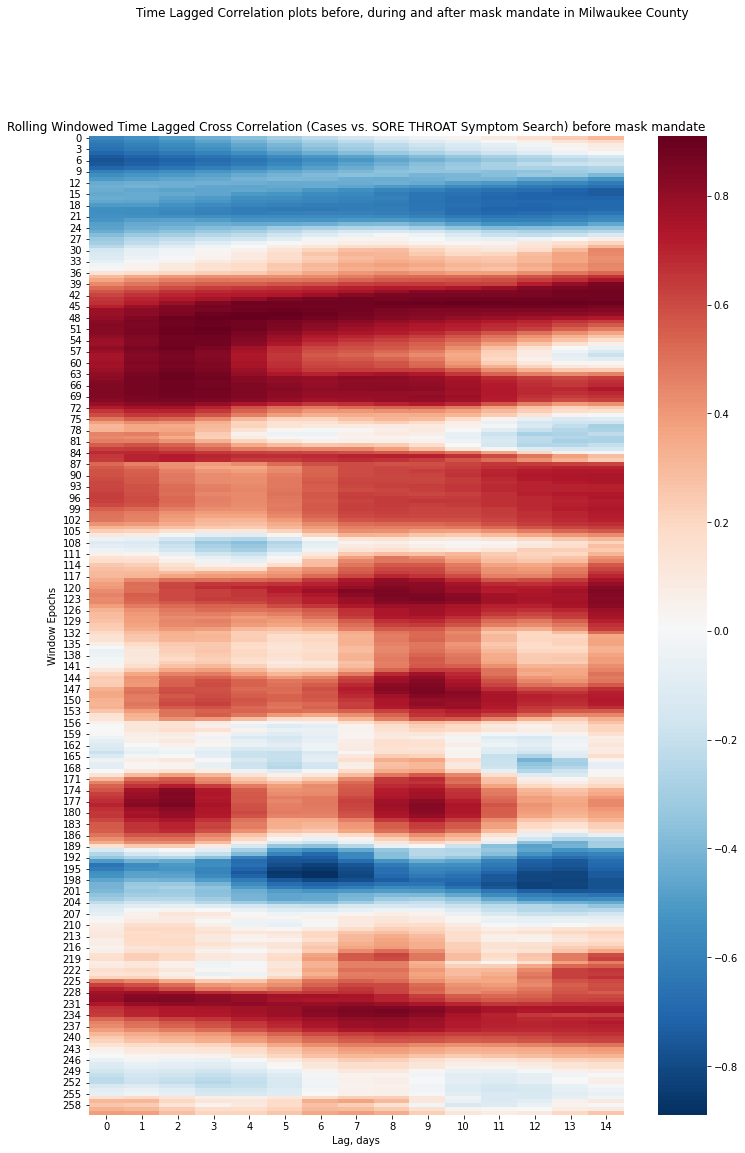

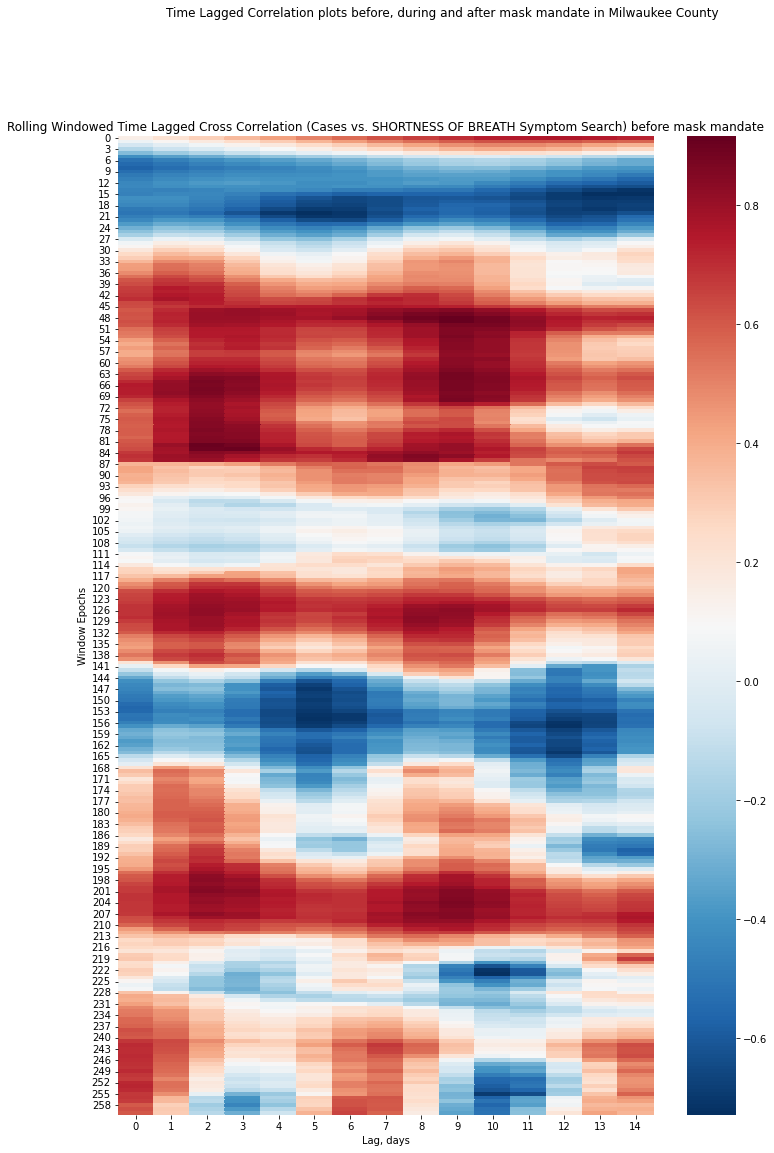

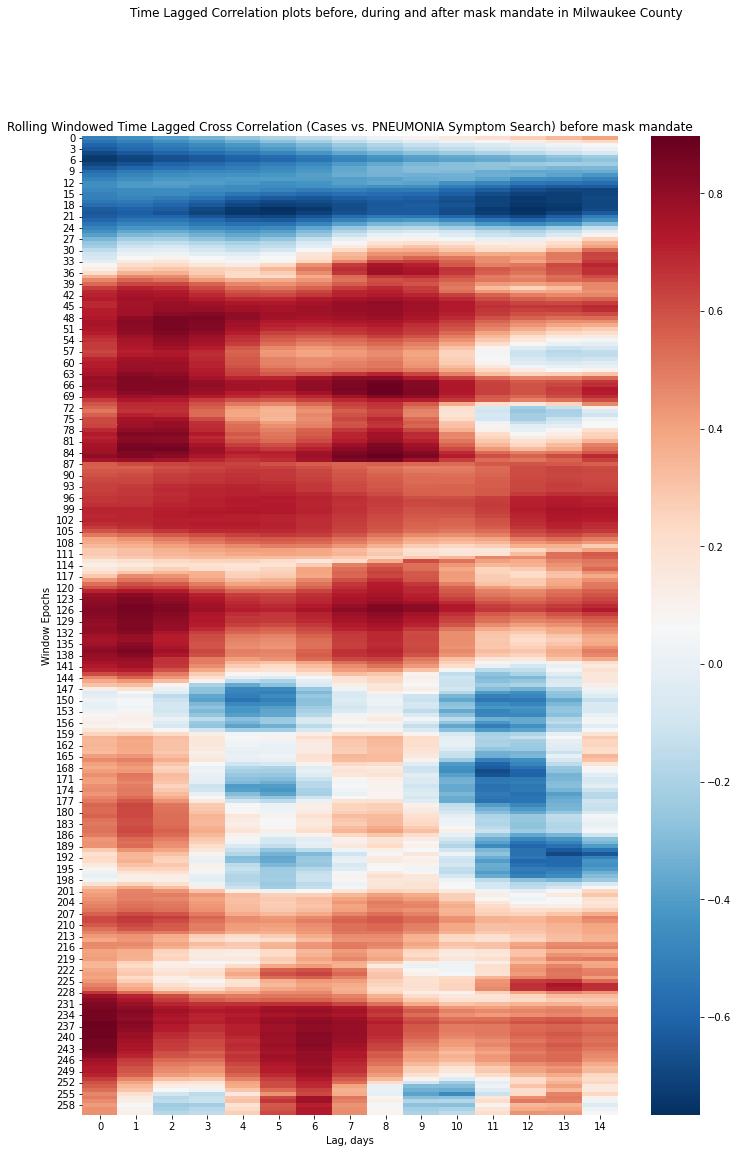

In [39]:
for i in top_symptoms:
  rss = window_corr(df_wave1.append(df_wave2).append(df_wave3), i)
  plot_corr2(rss, i)

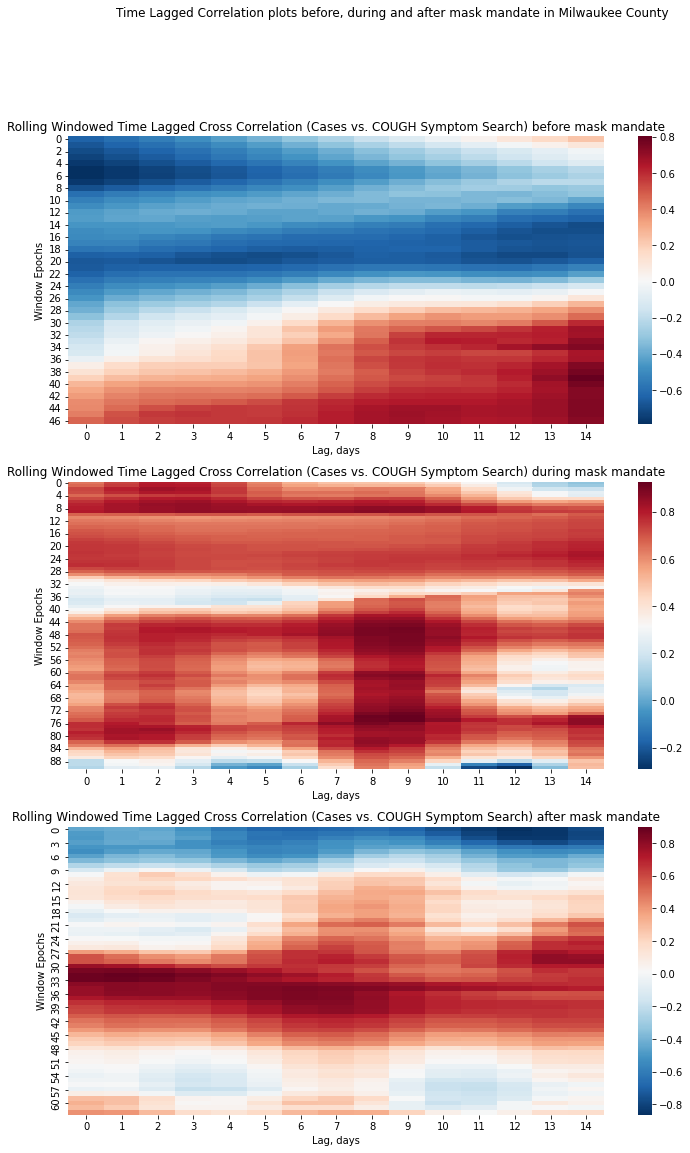

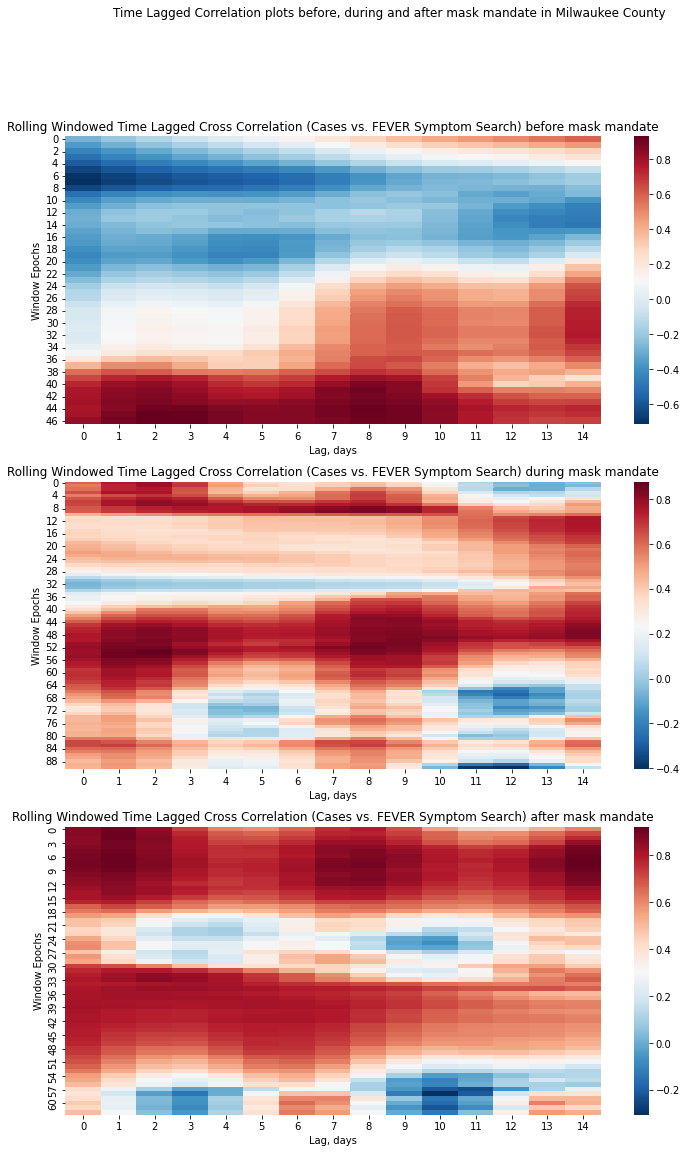

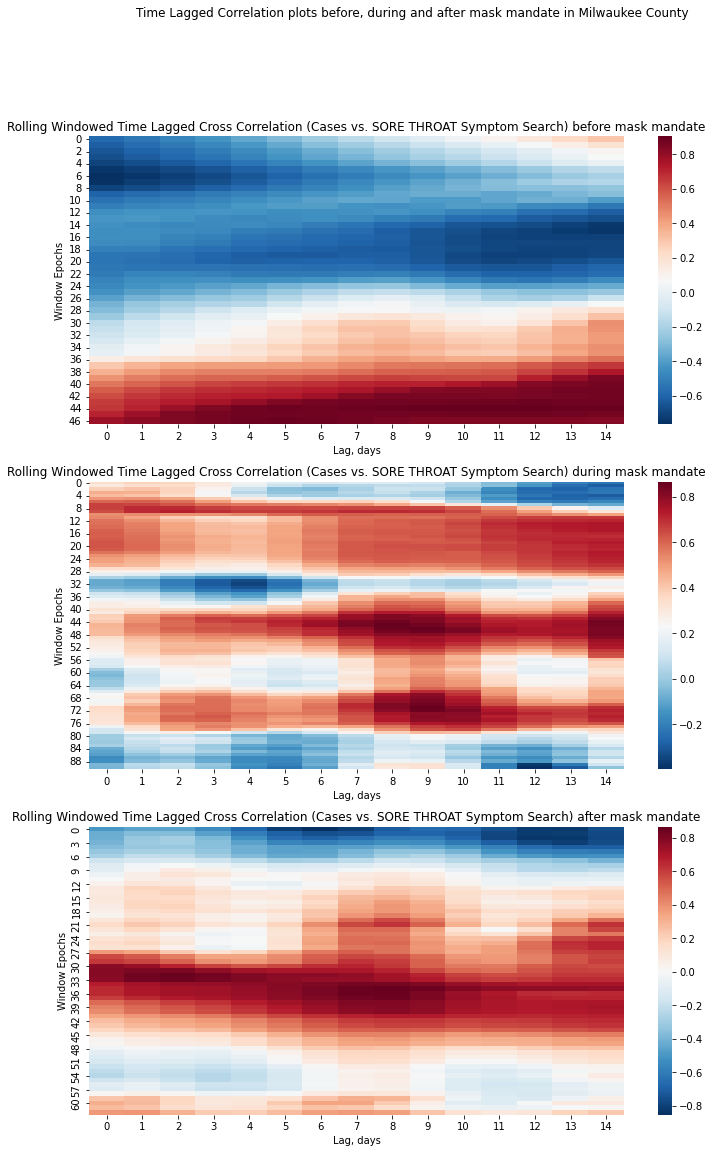

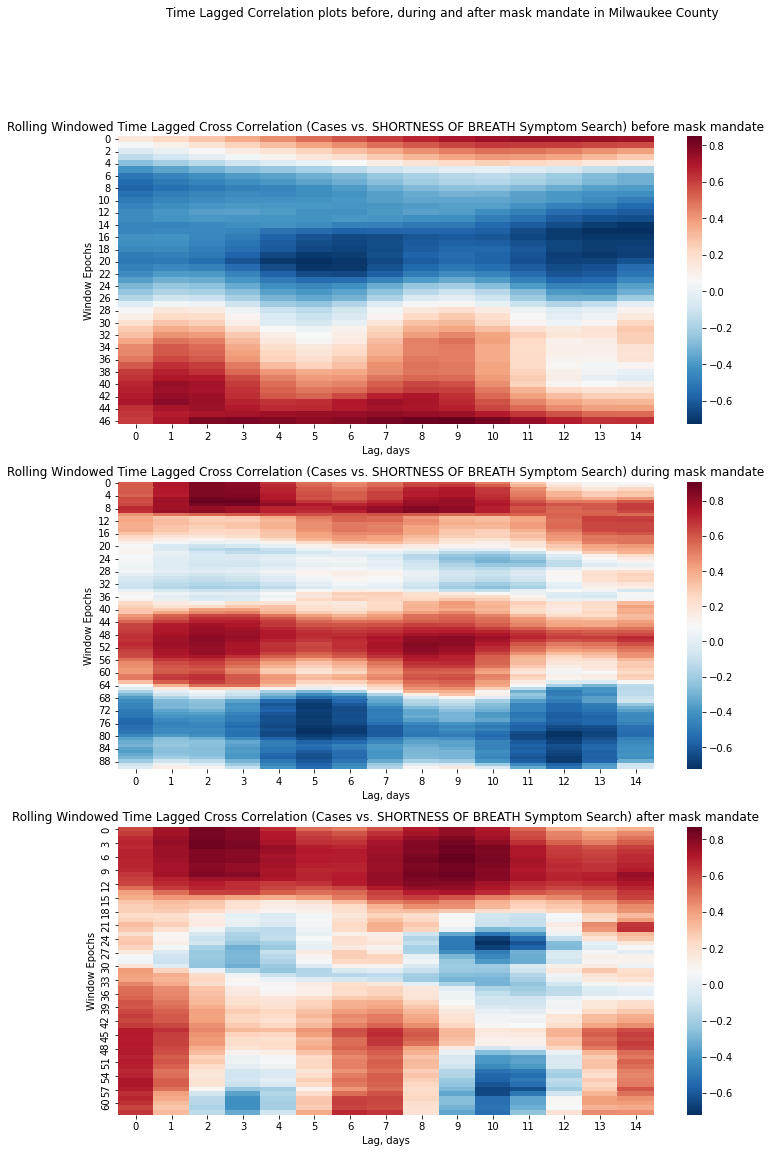

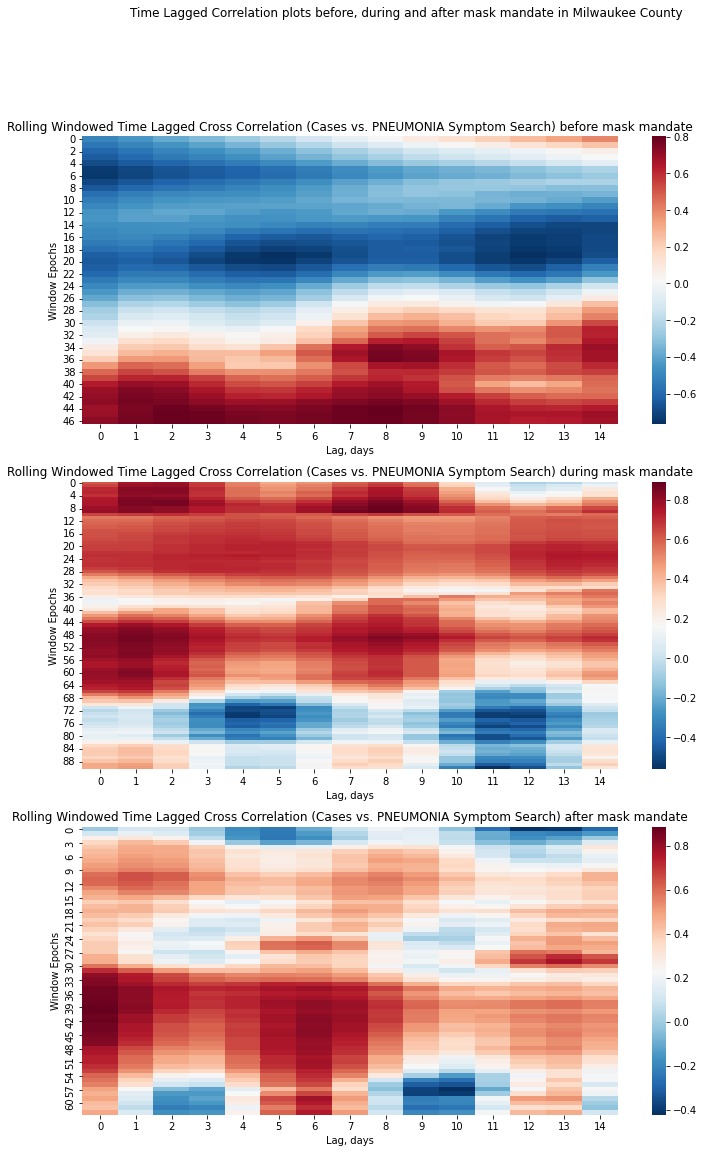

In [28]:
for i in top_symptoms:
  rss1, rss2, rss3 = window_corr(df_wave1, i),window_corr(df_wave2, i), window_corr(df_wave3, i)
  plot_corr(rss1, rss2, rss3, i)

### Difference in Difference Modeling

In [16]:
mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/archive/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
df_control_trends = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/US_NJ_34003.csv')
df_control_mask = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021['County_Name'] == 'Bergen County') & (mask_mandates_april_2020_aug_2021['State_Tribe_Territory'] == 'NJ')]

In [17]:
cols = list(df_columns['column'])
df_control_trends = df_control_trends[df_control_trends.columns.intersection(cols)]
df_control_trends = df_control_trends[(df_control_trends['date'] >= '2020-02-01') & (df_control_trends['date'] <= '2021-10-01')]
df_control_trends = df_control_trends.fillna(0)

df_control_mask = df_control_mask[['date', 'Face_Masks_Required_in_Public']].rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})

df_control_mask['date'] = pd.to_datetime(df_control_mask['date'])
df_control_trends['date'] = pd.to_datetime(df_control_trends['date'])
df_control =  df_control_trends.merge(df_control_mask, how='inner', on='date')
df_control['mask_required'] = df_control['mask_required'].replace(np.nan, 'No')

df_control_wave1 = df_control[(df_control['date'] >= '2020-03-01') & (df_control['date'] < '2020-08-01')]
df_control_wave2 = df_control[(df_control['date'] >= '2020-08-01') & (df_control['date'] <= '2021-03-30')]
df_control_wave3 = df_control[df_control['date'] >= '2021-03-30']
df_control_wave1.reset_index(inplace = True)
df_control_wave2.reset_index(inplace = True)
df_control_wave3.reset_index(inplace = True)
df_control_wave1[covid_symptoms_short] = df_control_wave1[covid_symptoms]
df_control_wave1 = df_control_wave1.drop(covid_symptoms, axis = 1)
df_control_wave1 = df_control_wave1[top_symptoms + ["date", "mask_required"]]
df_control_wave2[covid_symptoms_short] = df_control_wave2[covid_symptoms]
df_control_wave2 = df_control_wave2.drop(covid_symptoms, axis = 1)
df_control_wave2 = df_control_wave2[top_symptoms + ["date", "mask_required"]]
df_control_wave3[covid_symptoms_short] = df_control_wave3[covid_symptoms]
df_control_wave3 = df_control_wave3.drop(covid_symptoms, axis = 1)
df_control_wave3 = df_control_wave3[top_symptoms + ["date", "mask_required"]]

df_treatment_wave1 = df_wave1[top_symptoms + ["date", "mask_required"]]
df_treatment_wave2 = df_wave2[top_symptoms + ["date", "mask_required"]]
df_treatment_wave3 = df_wave3[top_symptoms + ["date", "mask_required"]]

In [18]:
df_control_did = df_control_wave1.sample(n = 60).append(df_control_wave2.sample(n = 180)).append((df_control_wave3[df_control_wave3['date'] <= '2021-05-27']).sample(n = 40))
#(df_control_wave1[df_control_wave1['date'] >= '2020-04-10']).append(df_control_wave2)
df_treatment_did = df_treatment_wave1.sample(n = 60).append(df_treatment_wave2.sample(n = 180)).append((df_treatment_wave3[df_treatment_wave3['date'] <= '2021-05-27']).sample(n = 40))
#(df_treatment_wave1[df_treatment_wave1['date'] >= '2020-04-10']).append(df_treatment_wave2)
print(df_control_did.shape, df_treatment_did.shape)

df_control_did['t'] = np.where((df_control_did['date'] >= '2020-08-01') & (df_control_did['date'] <= '2021-03-30') ,1, 0)
df_control_did['g'] = 0
df_treatment_did['t'] = np.where((df_treatment_did['date'] >= '2020-08-01') & (df_treatment_did['date'] <= '2021-03-30') ,1, 0)
df_treatment_did['g'] = 1

df_did = df_control_did.append(df_treatment_did)
df_did['month'] = df_did['date'].dt.month
df_did['year'] = df_did['date'].dt.year
df_did = df_did.drop(["date", "mask_required"], axis = 1)
df_did['gt'] = df_did['g']*df_did['t']
df_did.reset_index(inplace = True)
df_did = df_did.drop("index", axis = 1)
df_did.head()

(280, 7) (280, 7)


,cough,fever,sore throat,shortness of breath,pneumonia,t,g,month,year,gt
0,4.83,5.93,1.39,1.13,1.73,0,0,4,2020,0
1,2.47,4.08,1.17,0.67,0.62,0,0,7,2020,0
2,3.64,10.08,1.26,0.78,0.99,0,0,5,2020,0
3,2.52,3.42,1.00,0.68,0.75,0,0,6,2020,0
4,5.59,6.45,1.58,1.36,2.04,0,0,4,2020,0


In [19]:
did_groupby = df_did.groupby(['g', 't']).mean().drop(['gt', 'month', 'year'], axis = 1)
did_groupby = did_groupby.reset_index()
did_groupby

,g,t,cough,fever,sore throat,shortness of breath,pneumonia
0,0,0,3.507400,4.585400,1.277900,0.771000,0.917400
1,0,1,3.416556,3.824056,1.303556,0.691278,0.911333
2,1,0,4.427121,4.084596,1.604848,0.789949,1.039545
3,1,1,3.292928,2.993329,1.304213,0.649254,0.806823


In [20]:
def ols_regression(df, columns):
  coeff = []
  for i in columns:
    did = sm.OLS(endog = df[i], exog = df[['g', 't', 'gt', 'year', 'month']]).fit()
    coeff.append(round(did.params[2], 3))
  return coeff

In [21]:
coeffs = ols_regression(df_did, top_symptoms)
df_coeffs = pd.DataFrame(coeffs).T
df_coeffs.columns = top_symptoms
df_coeffs.head()

,cough,fever,sore throat,shortness of breath,pneumonia
0,-1.042,-0.334,-0.327,-0.061,-0.227


Text(0, 0.5, 'Relative Seach Value (RSV)')

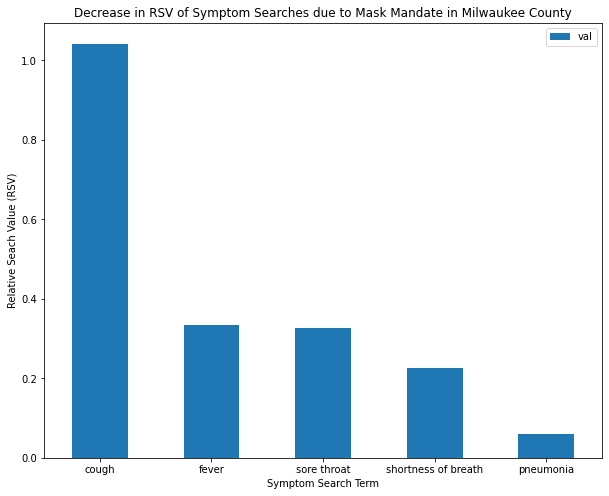

In [22]:
coeffs.sort(reverse=False)
df = pd.DataFrame({'symptom':top_symptoms, 'val':list(map(abs, coeffs))})
ax = df.plot.bar(x='symptom', y='val', rot=0, figsize=(10, 8))
plt.title('Decrease in RSV of Symptom Searches due to Mask Mandate in Milwaukee County')
plt.xlabel('Symptom Search Term')
plt.ylabel('Relative Seach Value (RSV)')

In [23]:
pct_change_treatment = -1 * np.array(coeffs) * 100 / np.array(did_groupby[(did_groupby['g'] == 1) & (did_groupby['t'] == 0)].iloc[:,2:])
pct_change_treatment = list(pct_change_treatment[0])

pct_change_control = 1 * (1 - (np.array(did_groupby[(did_groupby['g'] == 0) & (did_groupby['t'] == 1)].iloc[:,2:]) / np.array(did_groupby[(did_groupby['g'] == 0) & (did_groupby['t'] == 0)].iloc[:,2:])))*100
pct_change_control = list(pct_change_control[0])

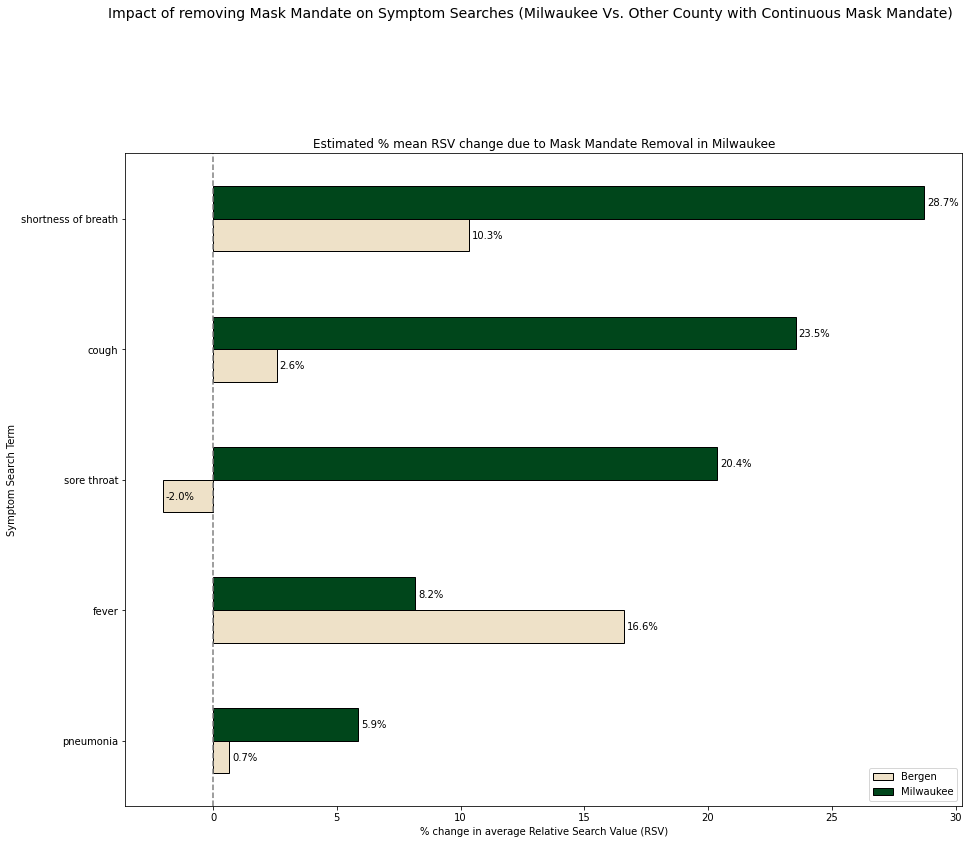

In [24]:
viz_did = pd.DataFrame({'Bergen': pct_change_control, 'Milwaukee': pct_change_treatment}, index = top_symptoms)
viz_did = viz_did.sort_values(by=['Milwaukee'], ascending = True)
ax = viz_did.plot(kind = "barh", rot=0, figsize = (15, 12), color = ['#EEE1C8', '#00461B'], edgecolor='black')
plt.suptitle('Impact of removing Mask Mandate on Symptom Searches (Milwaukee Vs. Other County with Continuous Mask Mandate)', y=1.05, fontsize=14)
plt.title('Estimated % mean RSV change due to Mask Mandate Removal in Milwaukee', fontsize=12)
plt.ylabel('Symptom Search Term')
plt.xlabel('% change in average Relative Search Value (RSV)')
plt.axvline(x = 0, color = 'gray', linestyle = '--', label = 'No change in RSV values')
for p in ax.patches:
  ax.annotate(str(round(p.get_width(), 1)) + '%', (p.get_width() + 0.1, p.get_y() + 0.1))